In [43]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.11.0


In [12]:
# Setup file paths
DATA_PATH = '/n/groups/price/martin/scTRS_data'

In [21]:
# Load TMS raw data: FACS
data_tms = dl.load_tms_raw(DATA_PATH, data_name='facs', 
                           flag_size_factor=True, total_ct_per_cell=1e4, 
                           flag_log1p=True)
print('# TMS data: n_cell=%d, n_gene=%d'%(data_tms.shape[0], data_tms.shape[1]))

Trying to set attribute `.obs` of view, copying.


# TMS data: n_cell=110096, n_gene=22966


/n/groups/price/martin/scTRS_data/tms_processed_data/Marrow_facs.h5ad


Trying to set attribute `.uns` of view, copying.


# TMS Liver_facs data: n_cell=8391, n_gene=22899


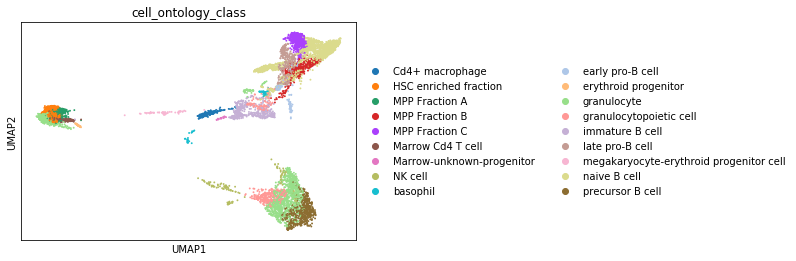

In [73]:
# Load TMS processed data: FACS
adata = dl.load_tms_processed(DATA_PATH, data_name='Marrow_facs')
ind_select = ['nan' not in x for x in adata.obs['cell_ontology_class']]
adata = adata[ind_select, :]
print('# TMS Liver_facs data: n_cell=%d, n_gene=%d'%(adata.shape[0], adata.shape[1]))
sc.pl.umap(adata, color='cell_ontology_class')

In [59]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
# Find the mouse ortholog genes 
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]
df_geneannot = df_geneannot.loc[df_geneannot.index!='N/A']
gene_list = list(set(df_geneannot.index) & set(adata.var_names))
gene_list.sort()
df_geneannot = df_geneannot.loc[gene_list]

In [47]:
gp = GProfiler(return_dataframe=True)
df_orth = gp.orth(organism='hsapiens',
                  query=list(df_geneannot.index),
                  target='mmusculus')

In [74]:
blood_trait_list = [x for x in df_geneannot.columns if 'blood' in x]
# A naive way to score cells 
for trait in blood_trait_list:
    gene_list = df_geneannot.index[df_geneannot[trait]>10]
    adata.obs['TRS_%s'%trait] = adata[:,gene_list].X.sum(axis=1)
    print(trait, len(gene_list))

UKB_460K.blood_EOSINOPHIL_COUNT 124
UKB_460K.blood_HIGH_LIGHT_SCATTER_RETICULOCYTE_COUNT 156
UKB_460K.blood_LYMPHOCYTE_COUNT 106
UKB_460K.blood_MEAN_CORPUSCULAR_HEMOGLOBIN 244
UKB_460K.blood_MEAN_PLATELET_VOL 398
UKB_460K.blood_MEAN_SPHERED_CELL_VOL 188
UKB_460K.blood_MONOCYTE_COUNT 133
UKB_460K.blood_PLATELET_COUNT 261
UKB_460K.blood_PLATELET_DISTRIB_WIDTH 197
UKB_460K.blood_RBC_DISTRIB_WIDTH 207
UKB_460K.blood_RED_COUNT 156
UKB_460K.blood_WHITE_COUNT 75


<Figure size 576x576 with 0 Axes>

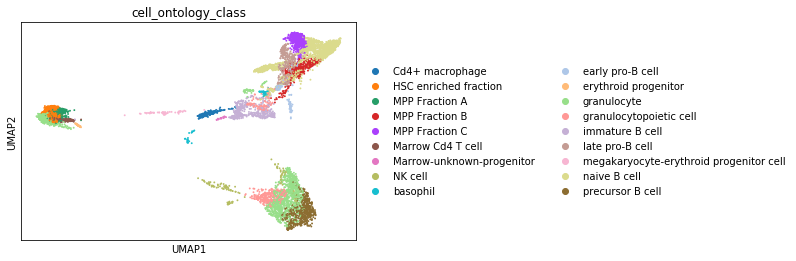

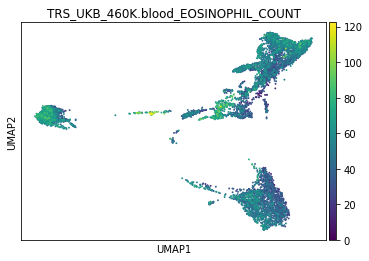

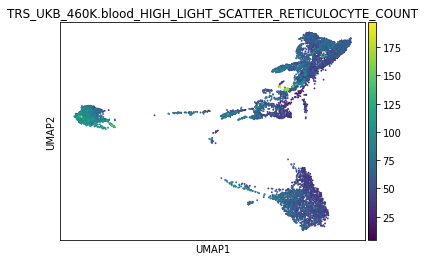

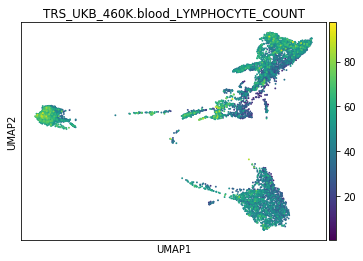

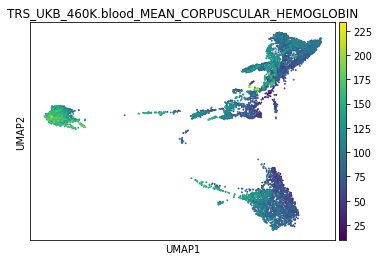

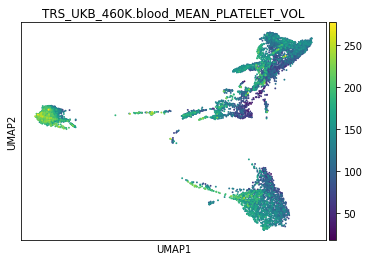

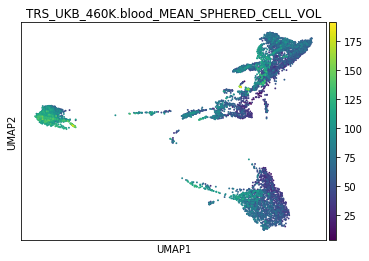

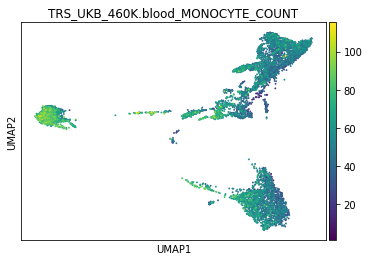

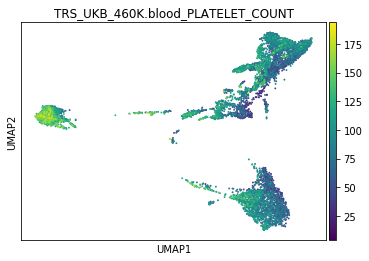

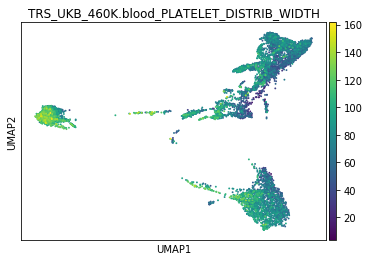

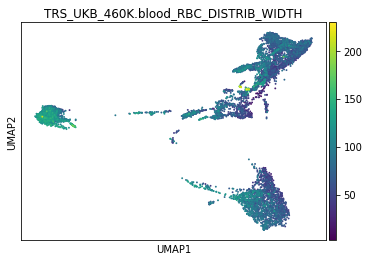

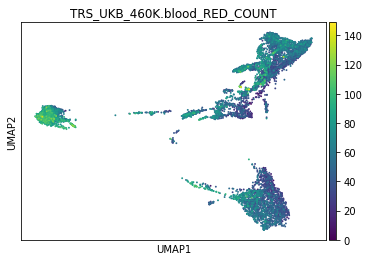

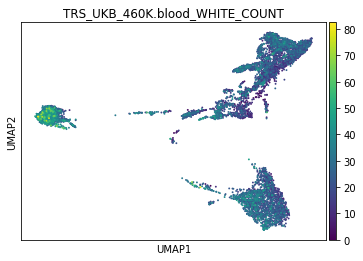

In [80]:
FIG_PATH='/home/jz286/gwas_informed_scRNAseq/results/fig_demo'
plt.figure(figsize=[8,8])
sc.pl.umap(adata, color='cell_ontology_class', save='_celltype.pdf')
for trait in blood_trait_list:
    sc.pl.umap(adata, color='TRS_%s'%trait, save='_%s.pdf'%(trait))